# Calculate RXE for public dataset, females only based on Apua's script

In [1]:
import re
import functools
import numpy as np
import pandas as pd
from os import environ
from plotnine import *
from gtfparse import read_gtf
from scipy.stats import variation
from warnings import filterwarnings
from scipy.stats import mannwhitneyu
from matplotlib.cbook import mplDeprecation

In [2]:
filterwarnings("ignore",category=mplDeprecation)
filterwarnings('ignore', category=UserWarning, module='plotnine.*')
filterwarnings('ignore', category=DeprecationWarning, module='plotnine.*')

In [3]:
environ['NUMEXPR_MAX_THREADS'] = '16'

In [4]:
config = {
    'pheno_file': '/ceph/users/jbenja13/projects/sex_sz_ria/input/gtex_v8/_m/gtex_v8_sample_data_TEage_analysis.txt',
    'tpm_file': '/ceph/users/jbenja13/projects/sex_sz_ria/input/gtex_v8/_m/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz',
    'gtf': '/ceph/genome/human/gencode26/gtf.ALL/_m/gencode.v26.chr_patch_hapl_scaff.annotation.gtf',
}

In [5]:
@functools.lru_cache()
def get_pheno():
    return pd.read_csv(config['pheno_file'], index_col=0, sep='\t')


@functools.lru_cache()
def get_gtf(gtf_file):
    return read_gtf(gtf_file)

In [6]:
def gene_annotation():
    gtf0 = get_gtf(config['gtf'])
    gtf = gtf0[gtf0["feature"] == "gene"]
    return gtf[["gene_id", "gene_name", "seqname", "start", "end", "strand"]]


def chrom_type(chrom):
    if chrom=='chrX':
        return 'X'
    elif re.search('^chr(\d+)$', chrom):
        return 'autosome'
    else:
        return 'other'
    
    
def save_ggplot(p, fn):
    for ext in ['.pdf', '.png', '.svg']:
        p.save(fn+ext, width=10, height=7)
        

def rge(df, chrom):
    return df[df['seqname']==chrom][samples].mean() \
    - df[(df['chrom_type']=='autosome') & (df['seqname']!=chrom)][samples].mean()


In [7]:
gene_annot = gene_annotation()
gene_annot.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


,gene_id,gene_name,seqname,start,end,strand
0,ENSG00000223972.5,DDX11L1,chr1,11869,14409,+
12,ENSG00000227232.5,WASH7P,chr1,14404,29570,-
25,ENSG00000278267.1,MIR6859-1,chr1,17369,17436,-
28,ENSG00000243485.5,MIR1302-2HG,chr1,29554,31109,+
36,ENSG00000284332.1,MIR1302-2,chr1,30366,30503,+


In [8]:
tpm = pd.read_csv(config['tpm_file'], index_col=[0,1], sep='\t', skiprows=2, 
                  engine='c', compression="gzip")
log2tpm = np.log2(tpm + 1.0)
log2tpm.iloc[0:2, 0:5]

,,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0426-SM-5EGHI,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0626-SM-5N9CS,GTEX-1117F-0726-SM-5GIEN
Name,Description,,,,,
ENSG00000223972.5,DDX11L1,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000227232.5,WASH7P,3.287472,2.281253,3.061603,3.593354,2.106348


In [9]:
log2tpm.shape

(56200, 17382)

In [10]:
df0 = gene_annot.loc[:, ["gene_name", "seqname"]].merge(log2tpm.reset_index().set_index("Description"), 
                                                        right_index=True, left_on="gene_name").drop_duplicates(subset=['Name'])
df0['chrom_type'] = df0['seqname'].apply(chrom_type)
df0.shape

(56200, 17386)

In [11]:
df0.groupby('chrom_type').size()

chrom_type
X            2273
autosome    53380
other         547
dtype: int64

In [12]:
samples = [x for x in log2tpm.columns if x.startswith('GTEX')]
df = df0[(df0[samples].sum(axis=1) >= 0.2 * len(samples)) & (df0['chrom_type'] != 'other')]
df1  = df.groupby('chrom_type').mean().transpose()
df1['sample'] = df1.index
df1['RXE'] = df1['X'] - df1['autosome']
df1.head(2)

chrom_type,X,autosome,sample,RXE
GTEX-1117F-0226-SM-5GZZ7,2.650521,2.633196,GTEX-1117F-0226-SM-5GZZ7,0.017325
GTEX-1117F-0426-SM-5EGHI,1.831858,1.832020,GTEX-1117F-0426-SM-5EGHI,-0.000162


In [13]:
gtex_pheno = get_pheno().reset_index().loc[:, ['BioSample Accession', 'SAMPID', 'SMTSD', 
                                               'SEX', "AGE", "RACE", "ETHNCTY"]]
gtex_pheno = gtex_pheno[~(gtex_pheno['SMTSD'].isin(['Whole Blood', 'Skin - Not Sun Exposed (Suprapubic)']))]
gtex_pheno.head(2)

,BioSample Accession,SAMPID,SMTSD,SEX,AGE,RACE,ETHNCTY
3,SAMN11828160,GTEX-1117F-0011-R10a-SM-AHZ7F,Brain - Frontal Cortex (BA9),2,66,2,0
4,SAMN11829996,GTEX-1117F-0011-R10b-SM-CYKQ8,Brain - Frontal Cortex (BA9),2,66,2,0


In [14]:
df2 = df1.merge(gtex_pheno, left_index=True, right_on="SAMPID")
df2.loc[:, ['SMTSD', 'SEX', 'RXE']].groupby(['SMTSD', 'SEX']).describe()

RXE                      \
                                               count      mean       std   
SMTSD                                     SEX                              
Brain - Amygdala                          1    107.0  0.250700  0.062549   
                                          2     45.0  0.263439  0.079238   
Brain - Anterior cingulate cortex (BA24)  1    128.0  0.268955  0.061722   
                                          2     48.0  0.275970  0.068738   
Brain - Caudate (basal ganglia)           1    183.0  0.225503  0.063541   
                                          2     63.0  0.228794  0.072326   
Brain - Cerebellar Hemisphere             1    157.0  0.180589  0.036571   
                                          2     58.0  0.182544  0.048581   
Brain - Cerebellum                        1    174.0  0.137634  0.030049   
                                          2     67.0  0.153533  0.031005   
Brain - Cortex                            1    181.0  0.210844  0.039593   
                                          2     74.0  0.219618  0.040668   
Brain - Frontal Cortex (BA9)              1    153.0  0.270782  0.050528   
                                          2     56.0  0.267839  0.058949   
Brain - Hippocampus                       1    143.0  0.223248  0.062707   
                                          2     54.0  0.226282  0.075554   
Brain - Hypothalamus                      1    147.0  0.370170  0.102817   
                                          2     55.0  0.349283  0.103079   
Brain - Nucleus accumbens (basal ganglia) 1    182.0  0.294037  0.084185   
                                          2     64.0  0.292632  0.087428   
Brain - Putamen (basal ganglia)           1    156.0  0.192931  0.059013   
                                          2     49.0  0.198868  0.067711   
Brain - Spinal cord (cervical c-1)        1    102.0  0.212069  0.046175   
                                          2     57.0  0.223500  0.050279   
Brain - Substantia nigra                  1    101.0  0.237408  0.065151   
                                          2     38.0  0.251901  0.076617   

                                                                             \
                                                    min       25%       50%   
SMTSD                                     SEX                                 
Brain - Amygdala                          1    0.107439  0.207917  0.256562   
                                          2    0.038834  0.221498  0.281500   
Brain - Anterior cingulate cortex (BA24)  1    0.117160  0.222823  0.275395   
                                          2    0.086183  0.237381  0.293180   
Brain - Caudate (basal ganglia)           1    0.092427  0.181090  0.225255   
                                          2    0.101147  0.180651  0.235723   
Brain - Cerebellar Hemisphere             1    0.054995  0.160378  0.182760   
                                          2    0.041057  0.146615  0.190975   
Brain - Cerebellum                        1    0.069107  0.115112  0.138224   
                                          2    0.072653  0.134385  0.154505   
Brain - Cortex                            1    0.086061  0.181867  0.215497   
                                          2    0.116728  0.197712  0.221497   
Brain - Frontal Cortex (BA9)              1    0.112262  0.246723  0.283841   
                                          2    0.131224  0.237263  0.278365   
Brain - Hippocampus                       1    0.100684  0.176197  0.221240   
                                          2    0.079693  0.171761  0.226968   
Brain - Hypothalamus                      1    0.127088  0.295830  0.375103   
                                          2    0.140905  0.280062  0.352141   
Brain - Nucleus accumbens (basal ganglia) 1    0.080232  0.251762  0.303669   
                                          2    0.116142  0.218016  0.298403   
Brain - Putamen (basal gang

In [15]:
for tissue in df2.SMTSD.unique():
    for sex in [2, 1]:
        var = variation(df2[(df2['SMTSD']==tissue) & (df2['SEX']==sex)].RXE)
        print("There is %.3f variation for %s in %s." % (var, sex, tissue))

There is 0.184 variation for 2 in Brain - Cortex.
There is 0.187 variation for 1 in Brain - Cortex.
There is 0.200 variation for 2 in Brain - Cerebellum.
There is 0.218 variation for 1 in Brain - Cerebellum.
There is 0.218 variation for 2 in Brain - Frontal Cortex (BA9).
There is 0.186 variation for 1 in Brain - Frontal Cortex (BA9).
There is 0.314 variation for 2 in Brain - Caudate (basal ganglia).
There is 0.281 variation for 1 in Brain - Caudate (basal ganglia).
There is 0.296 variation for 2 in Brain - Nucleus accumbens (basal ganglia).
There is 0.286 variation for 1 in Brain - Nucleus accumbens (basal ganglia).
There is 0.337 variation for 2 in Brain - Putamen (basal ganglia).
There is 0.305 variation for 1 in Brain - Putamen (basal ganglia).
There is 0.292 variation for 2 in Brain - Hypothalamus.
There is 0.277 variation for 1 in Brain - Hypothalamus.
There is 0.223 variation for 2 in Brain - Spinal cord (cervical c-1).
There is 0.217 variation for 1 in Brain - Spinal cord (cervi

### Separate out tissues

In [16]:
for tissue in df2.SMTSD.unique():
    dft = df2[(df2['SMTSD']==tissue)].copy()
    stat, pval = mannwhitneyu(dft[(dft['SEX']==2)].RXE, # Assuming 2 is Female and 1 is male based on sample numbers
                              dft[(dft['SEX']==1)].RXE)
    print("Mann-WhitneyU for female vs male (RXE) for %s: %.4f" % (tissue, pval))

Mann-WhitneyU for female vs male (RXE) for Brain - Cortex: 0.0459
Mann-WhitneyU for female vs male (RXE) for Brain - Cerebellum: 0.0001
Mann-WhitneyU for female vs male (RXE) for Brain - Frontal Cortex (BA9): 0.4166
Mann-WhitneyU for female vs male (RXE) for Brain - Caudate (basal ganglia): 0.4011
Mann-WhitneyU for female vs male (RXE) for Brain - Nucleus accumbens (basal ganglia): 0.3973
Mann-WhitneyU for female vs male (RXE) for Brain - Putamen (basal ganglia): 0.3907
Mann-WhitneyU for female vs male (RXE) for Brain - Hypothalamus: 0.1038
Mann-WhitneyU for female vs male (RXE) for Brain - Spinal cord (cervical c-1): 0.1241
Mann-WhitneyU for female vs male (RXE) for Brain - Hippocampus: 0.3849
Mann-WhitneyU for female vs male (RXE) for Brain - Anterior cingulate cortex (BA24): 0.1723
Mann-WhitneyU for female vs male (RXE) for Brain - Cerebellar Hemisphere: 0.2746
Mann-WhitneyU for female vs male (RXE) for Brain - Substantia nigra: 0.2534
Mann-WhitneyU for female vs male (RXE) for Brai

### Interaction model

In [17]:
df2.SEX = df2.SEX.astype("category").cat.rename_categories({2: "Female", 1: "Male"})
df2.SEX = df2.SEX.cat.reorder_categories(["Female", "Male"], ordered=True)
df2.head(2)

,X,autosome,sample,RXE,BioSample Accession,SAMPID,SMTSD,SEX,AGE,RACE,ETHNCTY
6,2.188338,2.041579,GTEX-1117F-3226-SM-5N9CT,0.146760,SAMN02792461,GTEX-1117F-3226-SM-5N9CT,Brain - Cortex,Female,66,2,0
17,2.538457,2.331041,GTEX-111FC-3126-SM-5GZZ2,0.207416,SAMN02790901,GTEX-111FC-3126-SM-5GZZ2,Brain - Cortex,Male,61,3,0


In [18]:
df3 = df2.loc[:, ['RXE', 'SEX', 'SMTSD']]
df3.loc[:, "SEX"] = df3.SEX.cat.codes
df3.loc[:, "SMTSD"] = df3.SMTSD.astype("category").cat.codes
df3.head(2)

,RXE,SEX,SMTSD
6,0.146760,0,5
17,0.207416,1,5


In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

anova_df = df2.loc[:,['RXE','SEX','SMTSD']]

# ANOVA results with combinations of 2 groups:
formula = 'RXE ~ C(SEX) + C(SMTSD) + C(SEX):C(SMTSD)'
lm = ols(formula, anova_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df           F         PR(>F)
C(SEX)            0.009635     1.0    2.399967   1.214588e-01
C(SMTSD)          8.040562    12.0  166.909348  5.608443e-312
C(SEX):C(SMTSD)   0.044328    12.0    0.920185   5.254921e-01
Residual         10.501764  2616.0         NaN            NaN


#### No interaction between sex and brain region in GTEx

### Plot RXE

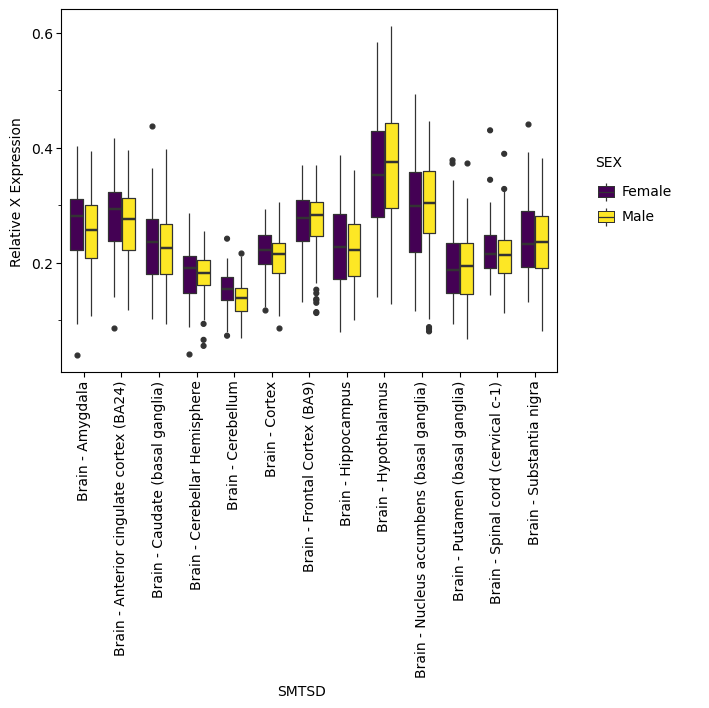

<ggplot: (8741883521829)>

In [20]:
p = ggplot(df2, aes(x='SMTSD', y='RXE', fill='SEX')) \
+ geom_boxplot() \
+ ylab("Relative X Expression")\
+ theme_matplotlib()
p + theme(axis_text_x = element_text(angle = 90))

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


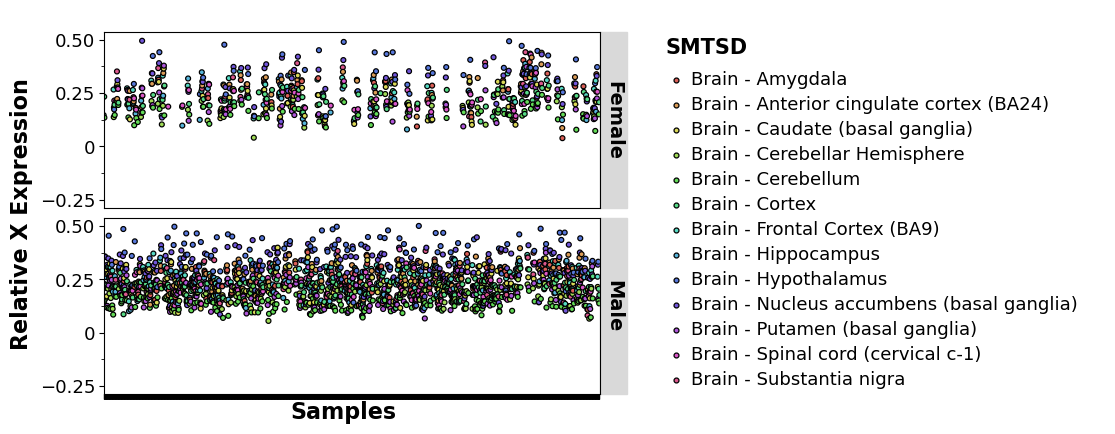

<ggplot: (8741959550085)>

In [21]:
p = ggplot(df2, aes(x='sample', y='RXE', fill='SMTSD')) \
+ geom_point() + ylim([-0.25, 0.5]) + xlab("Samples")\
+ ylab("Relative X Expression") + facet_grid("SEX~.")\
+ theme_matplotlib() \
+ theme(axis_text_x=element_blank(), 
        axis_text=element_text(size=13), 
        legend_title=element_text(size=15, face="bold"), 
        legend_text=element_text(size=13),
        axis_title=element_text(size=16, face="bold"), 
        strip_text=element_text(size=14, face="bold"))
p

In [22]:
df2.to_csv('RXE_public.csv')
save_ggplot(p, "RXE_public_bySex")

/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/jbenja13/.local/lib/python3.9/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logica